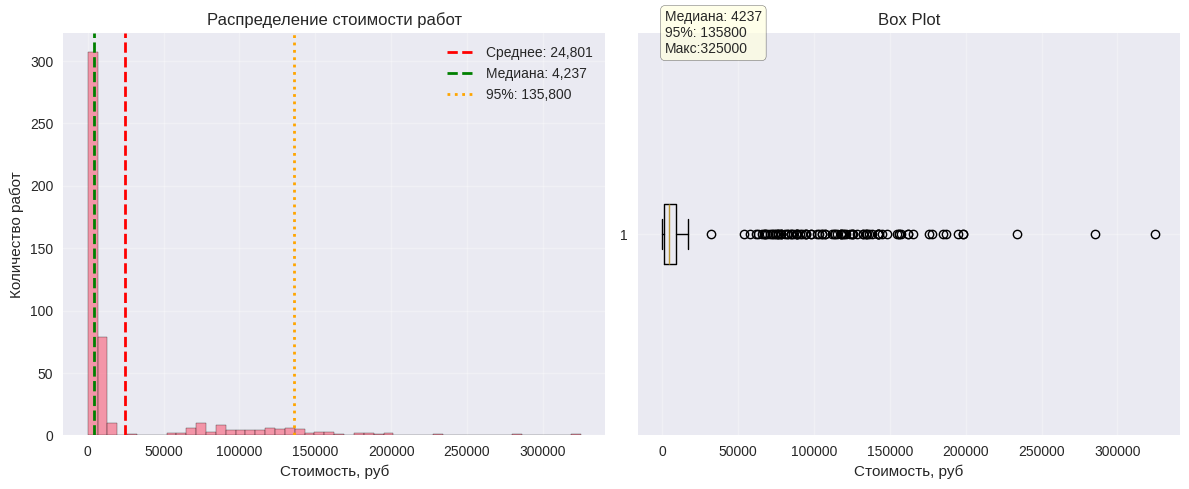

Основные выводы для постановки проблемы:
1. Среднее / Медиана = 5.85 (сильная асимметрия)
2. 95% / Медиана = 32.05 (тяжелый хвост)
3. 99% / Медиана = 46.14 (экстремальные значения)
4. Максимум / 95% = 2.39 (выбросы в хвосте)
5. 15.7% работ дают 80% общей стоимости
6. Коэффициент асимметрии = 2.51 (правая асимметрия)


In [ ]:
#Тема проекта: "Квантильные методы оценки рисков дорогостоящих дефектов в строительных объектах" Винокуров Т.Р.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('/content/fer_proc.xlsx')
costs = df['Прямые затраты, руб']

#Основные метрики
mean_cost = costs.mean()
median_cost = costs.median()
p95 = costs.quantile(0.95)
p99 = costs.quantile(0.99)

#Гистограмма с основными метриками
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(costs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_cost, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_cost:,.0f}')
plt.axvline(median_cost, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median_cost:,.0f}')
plt.axvline(p95, color='orange', linestyle=':', linewidth=2, label=f'95%: {p95:,.0f}')
plt.xlabel('Стоимость, руб')
plt.ylabel('Количество работ')
plt.title('Распределение стоимости работ')
plt.legend()
plt.grid(True, alpha=0.3)

#Ящик с усами(boxplot) для визуализации выбросов
plt.subplot(1, 2, 2)
plt.boxplot(costs, vert=False)
plt.xlabel('Стоимость, руб')
plt.title('Box Plot')
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f'Медиана: {median_cost:.0f}\n95%: {p95:.0f}\nМакс:{costs.max():.0f}',transform=plt.gca().transAxes, fontsize=10,bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))
plt.tight_layout()
plt.show()

#Правило Парето - 80/20(оставить?).Массив уже отсортирован по убыванию. Сколько % работ дают 80% стоимости?можно добавить график
cumulative_sum = np.cumsum(costs)
cumulative_percentage = cumulative_sum / costs.sum() * 100
items_percentage = np.arange(1, len(costs) + 1) / len(costs) * 100
idx_80 = np.argmax(cumulative_percentage >= 80)
perc_items_80 = items_percentage[idx_80]

#Вывод(исходные данные имеют сильную асимметрию и выбросы - продолжаем к квантильной регрессии)
print("Основные выводы для постановки проблемы:")
print(f"1. Среднее / Медиана = {mean_cost/median_cost:.2f} (сильная асимметрия)")
print(f"2. 95% / Медиана = {p95/median_cost:.2f} (тяжелый хвост)")
print(f"3. 99% / Медиана = {p99/median_cost:.2f} (экстремальные значения)")
print(f"4. Максимум / 95% = {costs.max()/p95:.2f} (выбросы в хвосте)")
print(f"5. {perc_items_80:.1f}% работ дают 80% общей стоимости")
print(f"6. Коэффициент асимметрии = {costs.skew():.2f} (правая асимметрия)")


In [ ]:
#Добавим признаки для построения регрессии - тип локации проведения работы и чел.ч(уже есть в исх.данных).
def get_location_type(work_name):
    #Берем часть после "/", т.к. значения могут повторяться в двух частях
    if '/' in str(work_name):
        loc = str(work_name).split('/')[-1].lower()
    else:
        loc = str(work_name).lower()
    #По ключевым словам определяем локацию строительных работ
    if 'кровл' in loc or 'крыш' in loc or 'стропил' in loc:
        return 'Кровля'
    elif 'фасад' in loc or 'стен' in loc or 'штукатурк' in loc:
        return 'Фасад'
    elif 'пол' in loc or 'паркет' in loc or 'плитк' in loc:
        return 'Полы'
    elif 'окон' in loc or 'двер' in loc:
        return 'Окна/Двери'
    elif 'лестниц' in loc or 'ступен' in loc:
        return 'Лестницы'
    elif 'водосточн' in loc or 'труб' in loc:
        return 'Водостоки'
    else:
        return 'Другое'
df['Тип локации'] = df['Наименование работ'].apply(get_location_type)

#Вывод первых 20(может быть добавить в новый файл?)
print(df[['Наименование работ', 'Тип локации', 'Затраты труда, чел.ч']].head(20))

print(f"\nВсего записей: {len(df)}")
#путь = '/content/fer_proc_location.xlsx'
#df.to_excel(путь, index=False)

                                   Наименование работ Тип локации  \
0   58-14 Смена покрытия из листовой стали / Замен...      Кровля   
1   58-14 Смена покрытия из листовой стали / Восст...      Кровля   
2   57-7 Ремонт покрытий из штучного паркета / Рес...        Полы   
3   58-24 Смена кровли из черепицы / Восстановлени...      Кровля   
4   57-7 Ремонт покрытий из штучного паркета / Рес...        Полы   
5   56-5 Ремонт оконных переплетов / Замена витраж...  Окна/Двери   
6   59-5 Ремонт ступеней / Замена мраморных ступен...    Лестницы   
7   53-21 Ремонт и восстановление герметизации сты...       Фасад   
8   61-4 Ремонт штукатурки потолков по камню / Рес...      Другое   
9   58-8 Смена отдельных листов металлической кров...      Кровля   
10  61-5 Ремонт штукатурки потолков / Реставрация ...      Другое   
11  58-5 Ремонт деревянных элементов конструкций к...      Кровля   
12  59-5 Ремонт ступеней / Восстановление гранитны...        Полы   
13  58-7 Ремонт отдельными местами

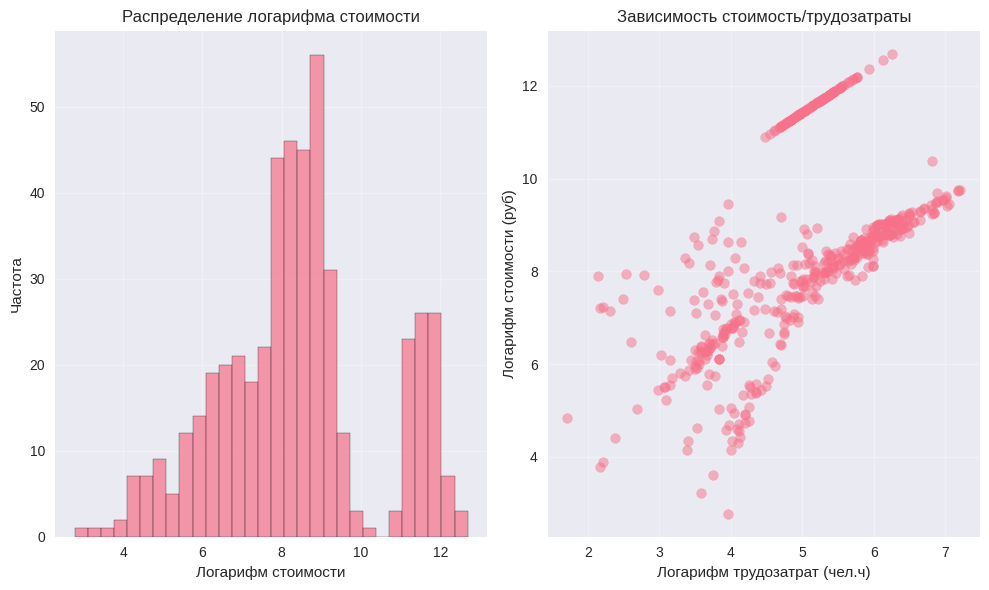

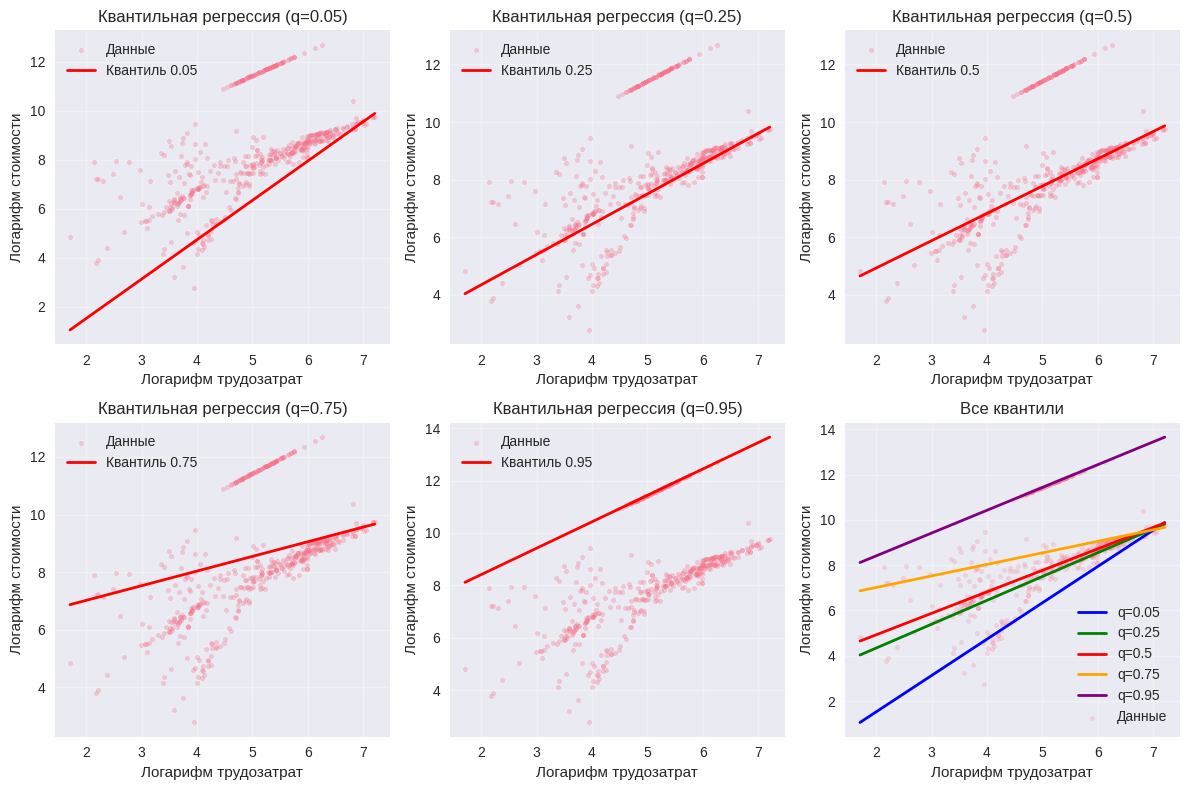

In [ ]:
#Квантильная регрессия и углубленная статистика
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

#Преобразуем категориальную переменную локации в числовую, т.к алгоритмы работают только с числовыми значениями
le = LabelEncoder()
df['Тип локации_код'] = le.fit_transform(df['Тип локации'])

# Определяем целевую переменную и признаки
X = df[['Затраты труда, чел.ч', 'Тип локации_код']]
y = df['Прямые затраты, руб']

#Добавим логарифмирование для работы с асимметричным распределением, которое подвердили в предыдущем пункте.
df['log_затраты'] = np.log1p(df['Прямые затраты, руб'])
df['log_труд'] = np.log1p(df['Затраты труда, чел.ч'])

#Визуализация логарифмированных данных. Можно увидеть, что распределение стало более симметричным, сжался правый хвост
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['log_затраты'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Логарифм стоимости')
plt.ylabel('Частота')
plt.title('Распределение логарифма стоимости')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df['log_труд'], df['log_затраты'], alpha=0.5)
plt.xlabel('Логарифм трудозатрат (чел.ч)')
plt.ylabel('Логарифм стоимости (руб)')
plt.title('Зависимость стоимость/трудозатраты')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Квантильная регрессия для разных квантилей
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
plt.figure(figsize=(12, 8))

X_sm = sm.add_constant(df['log_труд'])  #Добавляем константу,y=b0+b1x

for i, q in enumerate(quantiles):
    #Обучаем квантильную регрессию и для каждого квантиля получаем коэф. регрессии
    model = QuantReg(df['log_затраты'], X_sm)
    result = model.fit(q=q)

    # Предсказания для визуализации
    x_range = np.linspace(df['log_труд'].min(), df['log_труд'].max(), 100)
    X_range = sm.add_constant(x_range)
    y_pred = result.predict(X_range)

    plt.subplot(2, 3, i+1)
    plt.scatter(df['log_труд'], df['log_затраты'], alpha=0.3, s=10, label='Данные')
    plt.plot(x_range, y_pred, 'r-', linewidth=2, label=f'Квантиль {q}')
    plt.xlabel('Логарифм трудозатрат')
    plt.ylabel('Логарифм стоимости')
    plt.title(f'Квантильная регрессия (q={q})')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
#Строим сводный график всех квантилей и видим разный наклон, с сильной зависимостью от трудозатрат для дорогих работ и наоборот
x_range = np.linspace(df['log_труд'].min(), df['log_труд'].max(), 100)
X_range = sm.add_constant(x_range)

colors = ['blue', 'green', 'red', 'orange', 'purple']
for q, color in zip(quantiles, colors):
    model = QuantReg(df['log_затраты'], X_sm)
    result = model.fit(q=q)
    y_pred = result.predict(X_range)
    plt.plot(x_range, y_pred, color=color, linewidth=2, label=f'q={q}')

plt.scatter(df['log_труд'], df['log_затраты'], alpha=0.2, s=10, label='Данные')
plt.xlabel('Логарифм трудозатрат')
plt.ylabel('Логарифм стоимости')
plt.title('Все квантили')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

